# Data Wrangling

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import env

from pandas_profiling import ProfileReport

Pandas backend loaded 1.3.4
Numpy backend loaded 1.20.3
Pyspark backend loaded 3.2.1
Python backend loaded


In [4]:
database = 'titanic_db'
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/{database}'
titanic = pd.read_sql('SELECT * FROM passengers', url)

database = 'mall_customers'
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/{database}'
df = pd.read_sql('SELECT * FROM customers;', url)
df = df.set_index('customer_id')

In [5]:
print('--- Shape: {}'.format(df.shape))
print('--- Info')
df.info()
print('--- Descriptions')
print(df.describe(include='all'))

--- Shape: (200, 4)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
--- Descriptions
        gender         age  annual_income  spending_score
count      200  200.000000     200.000000      200.000000
unique       2         NaN            NaN             NaN
top     Female         NaN            NaN             NaN
freq       112         NaN            NaN             NaN
mean       NaN   38.850000      60.560000       50.200000
std        NaN   13.969007      26.264721       25.823522
min        NaN   18.000000      15.000000        1.000000
25%        NaN   28.750000      41.500000       34.750000
50%        NaN

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>, <AxesSubplot:>]],
      dtype=object)

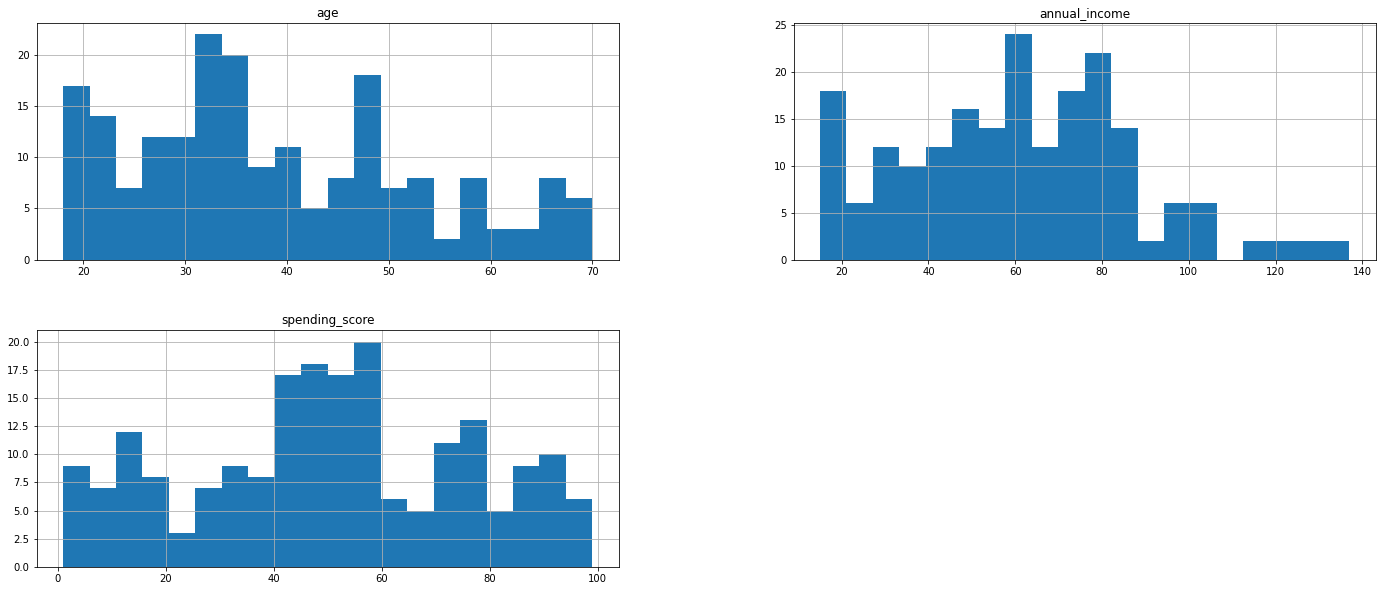

In [9]:
df.hist(figsize=(24, 10), bins=20)

869.0

## Investigate Nulls

In [10]:
# Nulls by column
pd.concat([
    titanic.isna().sum().rename('count'),
    titanic.isna().mean().rename('percent')
], axis=1)

count   percent
passenger_id      0  0.000000
survived          0  0.000000
pclass            0  0.000000
sex               0  0.000000
age             177  0.198653
sibsp             0  0.000000
parch             0  0.000000
fare              0  0.000000
embarked          2  0.002245
class             0  0.000000
deck            688  0.772166
embark_town       2  0.002245
alone             0  0.000000

In [27]:
# nulls by row
pd.concat([
    titanic.isna().sum(axis=1).rename('n_missing'),
    titanic.isna().mean(axis=1).rename('percent_missing'),
], axis=1).value_counts().sort_index()

n_missing  percent_missing
0          0.000000           182
1          0.076923           549
2          0.153846           160
dtype: int64

In [31]:
q1 = df.annual_income.quantile(.25)
q3 = df.annual_income.quantile(.75)
q1, q3 

(41.5, 78.0)

In [32]:
iqr = q3 - q1
typical values for k are either 1.5 or 3; a greater value means less points will be considered outliers. 
k = 1.5 
upper_bound = k * iqr + q3

In [34]:
df[df.annual_income > upper_bound]

gender  age  annual_income  spending_score  age_outliers  \
customer_id                                                            
199           Male   32            137              18             0   
200           Male   30            137              83             0   

             annual_income_outliers  spending_score_outliers  
customer_id                                                   
199                            4.25                        0  
200                            4.25                        0

In [36]:
df['annual_income_outliers'] = df.annual_income - upper_bound
# find cases where this is 0


gender  age  annual_income  spending_score  age_outliers  \
customer_id                                                            
199           Male   32            137              18             0   
200           Male   30            137              83             0   

             annual_income_outliers  spending_score_outliers  
customer_id                                                   
199                            4.25                        0  
200                            4.25                        0

In [38]:
def replace_negative_with_zero(x):
    if x < 0: 
        return 0 
    else:
        return x 

In [39]:
# instead of using if statment 
def replace_negative_with_zero2(x):
    return max([x, 0]) 

In [12]:
outlier_cols = [col for col in titanic if col.endswith('_outliers')]
for col in outlier_cols:
    print(f'~~~ {col}\n')
    data = titanic[col][titanic[col] > 0]
    print(data.describe())
    

                

In [16]:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print(f'~~~ {col}\n')
    data = df[col][df[col] > 0]
    print(data.describe())

## Investigate Outliers

In [29]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.
    
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)
    
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)
        
    return df

add_upper_outlier_columns(titanic, k=1.5)

titanic.head()

passenger_id  survived  pclass     sex   age  sibsp  parch     fare  \
0             0         0       3    male  22.0      1      0   7.2500   
1             1         1       1  female  38.0      1      0  71.2833   
2             2         1       3  female  26.0      0      0   7.9250   
3             3         1       1  female  35.0      1      0  53.1000   
4             4         0       3    male  35.0      0      0   8.0500   

  embarked  class  ...  embark_town alone  passenger_id_outliers  \
0        S  Third  ...  Southampton     0                      0   
1        C  First  ...    Cherbourg     0                      0   
2        S  Third  ...  Southampton     1                      0   
3        S  First  ...  Southampton     0                      0   
4        S  Third  ...  Southampton     1                      0   

   survived_outliers  pclass_outliers  age_outliers  sibsp_outliers  \
0                  0                0           0.0             0.0   
1                  0                0           0.0             0.0   
2                  0                0           0.0             0.0   
3                  0                0           0.0             0.0   
4                  0                0           0.0             0.0   

   parch_outliers  fare_outliers  alone_outliers  
0             0.0         0.0000               0  
1             0.0         5.6489               0  
2             0.0         0.0000               0  
3             0.0         0.0000               0  
4             0.0         0.0000               0  

[5 rows x 21 columns]

In [30]:
outlier_cols = [col for col in titanic if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = titanic[col][titanic[col] > 0]
    print(data.describe())

~~~
passenger_id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: passenger_id_outliers, dtype: float64
~~~
survived_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: survived_outliers, dtype: float64
~~~
pclass_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pclass_outliers, dtype: float64
~~~
age_outliers
count    11.000000
mean      4.960227
std       4.568171
min       0.187500
25%       0.687500
50%       5.187500
75%       6.187500
max      15.187500
Name: age_outliers, dtype: float64
~~~
sibsp_outliers
count    46.000000
mean      1.869565
std       1.678077
min       0.500000
25%       0.500000
50%       1.500000
75%       2.250000
max       5.500000
Name: sibsp_outliers, dtype: float64
~~~
parch_outliers
count    213.000000
mean       1.596244
std        0.882954
min    

In [ ]:
titanic

In [7]:
import mitosheet
mitosheet.sheet(titanic, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-a5236fb4-404b-4aa2-bf0e-af84117c50b7", "code": {"imports…

In [9]:
report = ProfileReport(titanic)

In [10]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]